In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch
import torchvision


In [2]:
# Step 1: Install Kaggle
!pip install kaggle

# Step 2: Upload Kaggle API Key (kaggle.json)
from google.colab import files
files.upload()  # Choose the kaggle.json file from your local system

# Step 3: Move kaggle.json to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 4: Download the Dataset
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

# Step 5: Unzip the Dataset
import zipfile
import os

# Create a directory for the dataset
dataset_dir = "deepfake_dataset"
os.makedirs(dataset_dir, exist_ok=True)

# Unzip the downloaded file
with zipfile.ZipFile("deepfake-and-real-images.zip", "r") as zip_ref:
    zip_ref.extractall(dataset_dir)

print(f"Dataset extracted to: {dataset_dir}")

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
100% 1.68G/1.68G [01:17<00:00, 24.0MB/s]
100% 1.68G/1.68G [01:17<00:00, 23.2MB/s]
Dataset extracted to: deepfake_dataset


In [3]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Class names: ['Fake', 'Real']


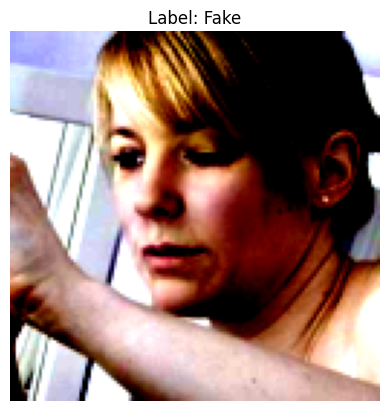

In [4]:
# Import necessary libraries
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Path to the dataset
TRAIN_IMAGES_PATH = "deepfake_dataset/Dataset/Train"

# Define transformations
IMG_SIZE = 128  # Reduced image size for faster processing
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Resize images to IMG_SIZE
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Load the dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=TRAIN_IMAGES_PATH, transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))  # 80% for training
valid_size = len(full_dataset) - train_size  # 20% for validation
train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

# Create DataLoaders
BATCH_SIZE = 16  # Smaller batch size for limited GPU memory
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Extract class names
class_names = full_dataset.classes
print(f"Class names: {class_names}")  # Should print ['Fake', 'Real']

# Sanity check: Visualize a sample image
import matplotlib.pyplot as plt
img, label = full_dataset[0]  # Get the first image and its label
plt.imshow(img.permute(1, 2, 0))  # Convert image for visualization
plt.title(f"Label: {class_names[label]}")
plt.axis('off')
plt.show()


In [5]:
pip install timm

In [6]:
import torch

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 't4 gpu')


In [7]:
import timm
# Replace with a lighter model
model = timm.create_model('mobilevit_xs', pretrained=True, num_classes=2).to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/9.34M [00:00<?, ?B/s]

In [9]:
# Import necessary libraries
import torch
from torch import nn, optim
from tqdm import tqdm
import timm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
model = timm.create_model('mobilevit_xs', pretrained=True, num_classes=2).to(device)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Training function
def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    loop = tqdm(dataloader, desc="Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        epoch_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy calculation
        _, preds = torch.max(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update progress bar
        loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    epoch_loss /= len(dataloader)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

# Validation function
def validate_one_epoch(model, dataloader, loss_fn, device):
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        loop = tqdm(dataloader, desc="Validating", leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            epoch_loss += loss.item()

            # Accuracy calculation
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    epoch_loss /= len(dataloader)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

# Training and validation loop
EPOCHS = 5
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_loss, train_accuracy = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    val_loss, val_accuracy = validate_one_epoch(model, valid_loader, loss_fn, device)

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Save the trained model
torch.save(model.state_dict(), "mobilevit_xs_deepfake_detector.pth")
print("Model training complete and saved as 'mobilevit_xs_deepfake_detector.pth'")

Epoch 1/5


Train Loss: 0.0895, Train Accuracy: 0.9659
Val Loss: 0.0714, Val Accuracy: 0.9729
Epoch 2/5


Train Loss: 0.0486, Train Accuracy: 0.9808
Val Loss: 0.0388, Val Accuracy: 0.9850
Epoch 3/5


Train Loss: 0.0399, Train Accuracy: 0.9842
Val Loss: 0.0551, Val Accuracy: 0.9799
Epoch 4/5


Train Loss: 0.0340, Train Accuracy: 0.9862
Val Loss: 0.0386, Val Accuracy: 0.9852
Epoch 5/5


Train Loss: 0.0294, Train Accuracy: 0.9881
Val Loss: 0.0528, Val Accuracy: 0.9811
Model training complete and saved as 'mobilevit_xs_deepfake_detector.pth'


In [13]:

# Load the trained model
model.load_state_dict(torch.load("mobilevit_xs_deepfake_detector.pth"))
model.eval()

# Function to predict and interpret the result
def predict_image(model, image_path, class_names, transform, device):
    from PIL import Image

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, dim=1)

    # Get class name
    class_name = class_names[predicted_class.item()]
    return class_name

# Example usage
image_path = "/content/deepfake_dataset/Dataset/Test/Fake/fake_100.jpg"  # Replace with your image path
class_names = ["Fake", "Real"]  # Adjust class names as per your dataset
# Define the transform for preprocessing the image (example)
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

predicted_class = predict_image(model, image_path, class_names, transform, device)
print(f"The predicted class for the image is: {predicted_class}")

The predicted class for the image is: Fake


<ipython-input-13-7edd99e75706>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mobilevit_xs_deepfake_detector.pth"))


In [14]:
from sklearn.metrics import classification_report

# Function to evaluate and print detailed classification metrics
def evaluate_model(model, dataloader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate classification metrics
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Return predictions and true labels for further analysis if needed
    return all_preds, all_labels

# Call the evaluation function
predictions, true_labels = evaluate_model(model, valid_loader, device, class_names)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.97      0.98     13894
        Real       0.97      0.99      0.98     14107

    accuracy                           0.98     28001
   macro avg       0.98      0.98      0.98     28001
weighted avg       0.98      0.98      0.98     28001



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


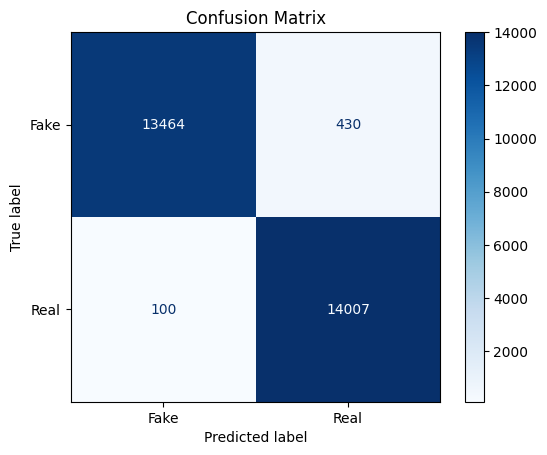

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


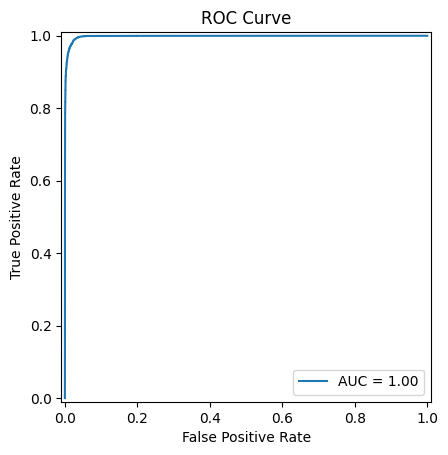

In [12]:
import torch
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, RocCurveDisplay
import numpy as np
import matplotlib.pyplot as plt

# Function to evaluate model on validation/test set and get predictions and true labels
def get_predictions_and_labels(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Get predictions and true labels
predictions, true_labels = get_predictions_and_labels(model, valid_loader, device)

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
def plot_roc_curve(model, dataloader, device, num_classes=2):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probability of class 1 (Fake)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
    plt.title("ROC Curve")
    plt.show()

# Plot the ROC curve
plot_roc_curve(model, valid_loader, device)

